# PUI Extra Credit 
Investigating the effect of plane trees on asthma

In [1]:
#setting up my usual packages
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import sys
import operator
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib as plt
import pylab as pl
import scipy as sp
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg
import geopandas.tools
from pandas import DataFrame
import json

try: 
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
PUIdata = os.getenv('PUIDATA')
print (PUIdata)

/home/cusp/rxl204/PUIdata


## Read in Data
For this study, I will be using the following sources of data: 

0. NYC Zip Code Level Shapefile
1. Street Tree Census
2. Asthma Discharge Rates
3. DOB Construction Permits
4. ACS Household Median Income 
5. 311 Cleanliness Related Complaints

### 1. NYC Zip Code Level Shapefile

In [3]:
if not os.path.isfile(PUIdata + "/ZIP_CODE_040114.shp"):
    print('Downloading...')
    os.system('curl -O https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip')
    os.system('mv YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip ' + PUIdata)
    os.system('unzip ' + PUIdata + '//YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip -d ' + PUIdata)
    if os.path.isfile(PUIdata + "/ZIP_CODE_040114.shp"):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')

File in place, proceed!


In [4]:
#read in nyc zipcode shapefile
zipsNYC = gpd.GeoDataFrame.from_file(PUIdata + '/ZIP_CODE_040114.shp')
zipsNYC.crs = from_epsg(2263) 
zipsNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [5]:
zipsNYC.ZIPCODE = zipsNYC.ZIPCODE.astype(int)

### 2. Street Tree Census

In [6]:
url = 'https://data.cityofnewyork.us/api/views/uvpi-gqnh/rows.csv?accessType=DOWNLOAD'
filename = 'tree.csv'

if not os.path.isfile(PUIdata + '/' + filename):
    print('Downloading...')
    os.system('wget ' + url)
    os.system('mv rows.csv?accessType=DOWNLOAD ' + filename)
    os.system('mv ' + filename + ' ' + PUIdata)
    if os.path.isfile(PUIdata + '/' + filename):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')


File in place, proceed!


In [7]:
#read files
df = pd.read_csv(PUIdata + '/tree.csv')
df.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


In [8]:
#check most common tree types
tree_sort = df.spc_common.value_counts().reset_index().sort(ascending=[False])
tree_sort.columns = ['Tree Type', 'Count']
tree_sort.head(10)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


,Tree Type,Count
0,London planetree,87014
1,honeylocust,64264
2,Callery pear,58931
3,pin oak,53185
4,Norway maple,34189
5,littleleaf linden,29742
6,cherry,29279
7,Japanese zelkova,29258
8,ginkgo,21024
9,Sophora,19338


In [9]:
tree_sort['ID'] = tree_sort.index
tree_sort.head()

,Tree Type,Count,ID
0,London planetree,87014,0
1,honeylocust,64264,1
2,Callery pear,58931,2
3,pin oak,53185,3
4,Norway maple,34189,4


In [10]:
tree_id = tree_sort[['Tree Type', 'ID']]
tree_id.head(10)

,Tree Type,ID
0,London planetree,0
1,honeylocust,1
2,Callery pear,2
3,pin oak,3
4,Norway maple,4
5,littleleaf linden,5
6,cherry,6
7,Japanese zelkova,7
8,ginkgo,8
9,Sophora,9


In [11]:
#merge back to df to assign ID to tree type 
df = df.merge(tree_id, left_on='spc_common', right_on='Tree Type')
df.columns

Index([u'tree_id', u'block_id', u'created_at', u'tree_dbh', u'stump_diam',
       u'curb_loc', u'status', u'health', u'spc_latin', u'spc_common',
       u'steward', u'guards', u'sidewalk', u'user_type', u'problems',
       u'root_stone', u'root_grate', u'root_other', u'trunk_wire',
       u'trnk_light', u'trnk_other', u'brch_light', u'brch_shoe',
       u'brch_other', u'address', u'postcode', u'zip_city', u'community board',
       u'borocode', u'borough', u'cncldist', u'st_assem', u'st_senate', u'nta',
       u'nta_name', u'boro_ct', u'state', u'latitude', u'longitude', u'x_sp',
       u'y_sp', u'council district', u'census tract', u'bin', u'bbl',
       u'Tree Type', u'ID'],
      dtype='object')

In [12]:
#filter data to include only plane trees
df = df.loc[df['spc_common'] == 'London planetree']
df.head()


,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl,Tree Type,ID
148225,192755,207508,08/31/2015,21,0,OffsetFromCurb,Alive,Fair,Platanus x acerifolia,London planetree,...,40.586357,-73.969744,9.926537e+05,152903.6306,47.0,37402.0,3320727.0,3.072350e+09,London planetree,0
148226,203719,302371,09/05/2015,11,0,OnCurb,Alive,Good,Platanus x acerifolia,London planetree,...,40.782428,-73.911171,1.008850e+06,224349.0366,22.0,105.0,4019061.0,4.008710e+09,London planetree,0
148227,203726,302371,09/05/2015,8,0,OnCurb,Alive,Poor,Platanus x acerifolia,London planetree,...,40.781735,-73.912020,1.008615e+06,224096.2740,22.0,105.0,4019059.0,4.008710e+09,London planetree,0
148228,195202,415896,09/01/2015,13,0,OnCurb,Alive,Fair,Platanus x acerifolia,London planetree,...,40.557103,-74.162670,9.390480e+05,142285.9579,51.0,14607.0,5072852.0,5.054910e+09,London planetree,0
148229,189465,219493,08/30/2015,22,0,OnCurb,Alive,Good,Platanus x acerifolia,London planetree,...,40.694733,-73.968211,9.930653e+05,192388.0651,35.0,191.0,3054331.0,3.018880e+09,London planetree,0


In [13]:
dfg= df.groupby('postcode')['spc_common'].count()
dfg.head()

postcode
83        54
10001     21
10002    388
10003    133
10004      8
Name: spc_common, dtype: int64

In [14]:
dfg = dfg.to_frame().reset_index()
dfg.head()

,postcode,spc_common
0,83,54
1,10001,21
2,10002,388
3,10003,133
4,10004,8


Other shrubs and trees which are fairly common and can trigger symptoms in some people include alder, ash, cypress, maple, mulberry and plane trees.

In [33]:
#read files
df1 = pd.read_csv(PUIdata + '/tree.csv')
df1.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


In [35]:
#selecting rows that contain "asthma-causing" tree types
suspect_list = ['alder', 'ash', 'cypress', 'maple', 'mulberry', 'planetree']


In [36]:
df_suspect = pd.DataFrame()

In [37]:
df_suspect.head()

""


In [38]:
for s in suspect_list: 
    temp = df1[df1['spc_common'].str.contains(s, na=False)]
    df_suspect = df_suspect.append(temp)

In [39]:
df_suspect.shape

(198424, 45)

In [40]:
df_suspect.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
40136,43433,314150,06/30/2015,27,0,OnCurb,Alive,Good,Alnus glutinosa,European alder,...,4101700,New York,40.778710,-73.797619,1.040300e+06,223046.5999,19.0,1017.0,4128999.0,4.057520e+09
67243,101706,501557,07/29/2015,7,0,OnCurb,Alive,Fair,Alnus glutinosa,European alder,...,2008700,New York,40.818137,-73.896770,1.012823e+06,237363.2022,17.0,87.0,2005597.0,2.027090e+09
67962,145627,301597,08/14/2015,3,0,OnCurb,Alive,Good,Alnus glutinosa,European alder,...,4013500,New York,40.771036,-73.900361,1.011849e+06,220201.6141,22.0,135.0,4014639.0,4.007700e+09
72610,195877,223072,09/01/2015,4,0,OnCurb,Alive,Good,Alnus glutinosa,European alder,...,3013900,New York,40.668506,-73.988532,9.874312e+05,182831.1892,39.0,139.0,3022872.0,3.010220e+09
82526,258314,500880,09/25/2015,3,0,OnCurb,Alive,Fair,Alnus glutinosa,European alder,...,2007500,New York,40.818468,-73.907271,1.009916e+06,237480.7364,17.0,75.0,2004535.0,2.026368e+09


In [41]:
df_suspect.spc_common.unique()

array(['European alder', 'ash', 'green ash', 'white ash', 'pond cypress',
       'bald cypress', 'false cypress', 'red maple', 'sycamore maple',
       'Amur maple', 'hedge maple', 'silver maple', 'Norway maple',
       'crimson king maple', 'sugar maple', 'Japanese maple', 'maple',
       'paperbark maple', 'tartar maple', 'black maple', 'Shantung maple',
       'trident maple', 'mulberry', 'London planetree'], dtype=object)

In [42]:
#get the count of suspects
tree_suspect = df_suspect.spc_common.value_counts().reset_index().sort(ascending=[False])
tree_suspect.columns = ['Tree Type', 'Count']
tree_suspect

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


,Tree Type,Count
0,London planetree,87014
1,Norway maple,34189
2,red maple,17246
3,green ash,16251
4,silver maple,12277
5,maple,7080
6,crimson king maple,5923
7,sugar maple,2844
8,sycamore maple,2731
9,ash,2609


In [43]:
#get a count of suspects by zipcode
dfsuszip= df_suspect.groupby('postcode')['spc_common'].count()
dfsuszip.head()

postcode
83        54
10001     26
10002    493
10003    188
10004      8
Name: spc_common, dtype: int64

In [44]:
dfsuszip = dfsuszip.to_frame().reset_index()

### 3. Asthma Discharge Rates

In [26]:
#asthma.to_csv('asthma.csv', encoding='utf-8')

In [45]:
dfas = pd.read_csv('https://raw.githubusercontent.com/rxl204/PUI2017_rxl204/master/asthma.csv')
dfas.head()

,Unnamed: 0,ZipCode,Discharges_2012-2014,Dicharge_Rate
0,0,10001.0,159.0,21.9
1,1,10002.0,592.0,23.9
2,2,10003.0,130.0,7.7
3,6,10007.0,14.0,2.9
4,7,10009.0,534.0,28.3


### 4. DOB Construction Permits

In [46]:
df_con = pd.read_csv('https://data.cityofnewyork.us/api/views/upjv-ar2g/rows.csv?accessType=DOWNLOAD')
df_con.head()

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,CENSUS_TRACT,NTA_NAME
0,QUEENS,4311785,87-77,PARSONS BLVD.,440154440,1,A2,Y,9765,41,...,NY,11354,7.183539e+09,11/03/2017 12:00:00 AM,2745274,40.707312,-73.802539,24.0,44602.0,Jamaica
1,MANHATTAN,1089326,49,ANN STREET,120029511,1,A2,N,92,14,...,NY,10018,2.123343e+09,11/03/2017 12:00:00 AM,2833706,40.710306,-74.006828,1.0,1501.0,Battery Park City-Lower Manhattan
2,QUEENS,4200517,118-04,101 AVE,420829125,1,A2,N,9486,2,...,NY,11420,7.184407e+09,11/03/2017 12:00:00 AM,2573400,40.689746,-73.826697,28.0,106.0,South Ozone Park
3,MANHATTAN,1014236,282,7TH AVENUE,121895280,2,A2,Y,776,40,...,NY,10001,2.122178e+09,11/03/2017 12:00:00 AM,2696921,40.746147,-73.994168,3.0,95.0,Midtown-Midtown South
4,MANHATTAN,1087167,233,BROADWAY,121402981,1,A2,Y,123,7501,...,NY,10004,2.122333e+09,11/03/2017 12:00:00 AM,2453788,40.712265,-74.007892,1.0,21.0,SoHo-TriBeCa-Civic Center-Little Italy


In [47]:
df_con.columns

Index([u'BOROUGH', u'Bin #', u'House #', u'Street Name', u'Job #',
       u'Job doc. #', u'Job Type', u'Self_Cert', u'Block', u'Lot',
       u'Community Board', u'Zip Code', u'Bldg Type', u'Residential',
       u'Special District 1', u'Special District 2', u'Work Type',
       u'Permit Status', u'Filing Status', u'Permit Type',
       u'Permit Sequence #', u'Permit Subtype', u'Oil Gas', u'Site Fill',
       u'Filing Date', u'Issuance Date', u'Expiration Date', u'Job Start Date',
       u'Permittee's First Name', u'Permittee's Last Name',
       u'Permittee's Business Name', u'Permittee's Phone #',
       u'Permittee's License Type', u'Permittee's License #',
       u'Act as Superintendent', u'Permittee's Other Title', u'HIC License',
       u'Site Safety Mgr's First Name', u'Site Safety Mgr's Last Name',
       u'Site Safety Mgr Business Name', u'Superintendent First & Last Name',
       u'Superintendent Business Name', u'Owner's Business Type',
       u'Non-Profit', u'Owner's Business

In [48]:
df_con['Job Start Date'] = pd.to_datetime(df_con['Job Start Date'])

In [49]:
df_con['Expiration Date'] = pd.to_datetime(df_con['Expiration Date'])

In [50]:
df_con['construction_days'] = df_con['Expiration Date'] - df_con['Job Start Date']
df_con.head()

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,CENSUS_TRACT,NTA_NAME,construction_days
0,QUEENS,4311785,87-77,PARSONS BLVD.,440154440,1,A2,Y,9765,41,...,11354,7.183539e+09,11/03/2017 12:00:00 AM,2745274,40.707312,-73.802539,24.0,44602.0,Jamaica,219 days
1,MANHATTAN,1089326,49,ANN STREET,120029511,1,A2,N,92,14,...,10018,2.123343e+09,11/03/2017 12:00:00 AM,2833706,40.710306,-74.006828,1.0,1501.0,Battery Park City-Lower Manhattan,1471 days
2,QUEENS,4200517,118-04,101 AVE,420829125,1,A2,N,9486,2,...,11420,7.184407e+09,11/03/2017 12:00:00 AM,2573400,40.689746,-73.826697,28.0,106.0,South Ozone Park,365 days
3,MANHATTAN,1014236,282,7TH AVENUE,121895280,2,A2,Y,776,40,...,10001,2.122178e+09,11/03/2017 12:00:00 AM,2696921,40.746147,-73.994168,3.0,95.0,Midtown-Midtown South,336 days
4,MANHATTAN,1087167,233,BROADWAY,121402981,1,A2,Y,123,7501,...,10004,2.122333e+09,11/03/2017 12:00:00 AM,2453788,40.712265,-74.007892,1.0,21.0,SoHo-TriBeCa-Civic Center-Little Italy,200 days


In [51]:
df_con['construction_days'] = df_con['construction_days'].dt.days

In [52]:
df_con['Zip Code'].dropna(inplace=True);

In [53]:
df_con['Zip Code'] = df_con['Zip Code'].astype('int');

In [54]:
df_con = df_con[['construction_days', 'Zip Code']]

In [55]:
df_condays = df_con.groupby(['Zip Code'], as_index=False)['construction_days'].sum()

In [56]:
df_condays['Zip Code'] = df_condays['Zip Code'].astype(int)
df_condays.head()

,Zip Code,construction_days
0,10000,10143.0
1,10001,3902072.0
2,10002,2157231.0
3,10003,3924700.0
4,10004,1088428.0


### 5. ACS Household Median Income

In [57]:
import readline
censusAPI = os.getenv('PUIDATA') + '/FactFinderAPI.txt'
f = open(os.getenv('PUIDATA') + '/FactFinderAPI.txt')
myAPI = f.readline()

In [58]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2014/acs5/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [ ]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())

In [ ]:
#extracting variables of B07011 that contain Median Income
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B07011") and 
 'Median income' in aff1y['variables'][k]['label']]

In [ ]:
#keyword for the number of households
keyNhouseholds = 'B07011_001E'
aff1y['variables'][keyNhouseholds]

In [ ]:
#keyword for the number of households with broarband access
keyNBB = 'B07011_001E'
aff1y['variables'][keyNBB]

In [ ]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2014/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

In [59]:
df_acs = pd.read_csv('https://raw.githubusercontent.com/rxl204/PUI2017_rxl204/master/ACS_14_5YR_B19013_with_ann.csv')
df_acs.head()

,GEO.id,GEO.id2,GEO.display-label,HD01_VD01,HD02_VD01
0,Id,Id2,Geography,Estimate; Median household income in the past ...,Margin of Error; Median household income in th...
1,0100000US,NaN,United States,53482,95
2,1400000US36001000100,36001000100,"Census Tract 1, Albany County, New York",30750,14345
3,1400000US36001000200,36001000200,"Census Tract 2, Albany County, New York",21283,6579
4,1400000US36001000300,36001000300,"Census Tract 3, Albany County, New York",31591,13372


In [60]:
df_acs = df_acs.rename(columns=df_acs.iloc[0]).drop(df_acs.index[0])

In [61]:
df_acs.dropna(inplace=True)

In [62]:
df_acs['Id2'] = df_acs['Id2'].astype(int)

In [63]:
zip_ct = pd.read_csv('https://raw.githubusercontent.com/rxl204/PUI2017_rxl204/master/ZIP_TRACT.csv')
zip_ct.head()

,﻿ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,501,36103158607,0.000000,1.000000,0.000000,1.000000
1,601,72001956600,0.136735,0.358911,0.347222,0.154270
2,601,72001956700,0.859996,0.636139,0.652778,0.842387
3,601,72001956300,0.003269,0.004950,0.000000,0.003343
4,602,72003430300,0.037744,0.272500,0.315789,0.055036


In [64]:
#merge acs median income data with census tract - zipcode conversion file
acs_zip = df_acs.merge(zip_ct, left_on = 'Id2', right_on = 'TRACT', how='inner')
acs_zip.head()

,Id,Id2,Geography,Estimate; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars),Margin of Error; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars),﻿ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,1400000US36001000100,36001000100,"Census Tract 1, Albany County, New York",30750,14345,12204,36001000100,0.239564,0.330490,0.036957,0.228785
1,1400000US36001000100,36001000100,"Census Tract 1, Albany County, New York",30750,14345,12207,36001000100,0.000000,0.011142,0.000000,0.004494
2,1400000US36001000200,36001000200,"Census Tract 2, Albany County, New York",21283,6579,12204,36001000200,0.026855,0.121535,0.054348,0.039019
3,1400000US36001000200,36001000200,"Census Tract 2, Albany County, New York",21283,6579,12207,36001000200,0.374366,0.057567,0.094340,0.224345
4,1400000US36001000200,36001000200,"Census Tract 2, Albany County, New York",21283,6579,12210,36001000200,0.370401,0.186765,0.215470,0.338299


In [65]:
acs_zip = acs_zip[acs_zip['Estimate; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars)'] != '-']

### 5. 311 Cleanliness Related Complaints

In [66]:
df_311 = pd.read_csv('https://data.cityofnewyork.us/api/views/h7rh-mvxa/rows.csv?accessType=DOWNLOAD')
df_311.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,22959537,03/27/2012 09:35:00 AM,03/29/2012 12:00:00 PM,DSNY,BCC - Queens West,Dirty Conditions,E2 Receptacle Violation,Sidewalk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22961593,03/28/2012 05:16:00 PM,03/31/2012 12:00:00 PM,DSNY,A - Manhattan,Dirty Conditions,E1 Improper Disposal,Sidewalk,10025.0,241 WEST 97 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.795485,-73.971649,"(40.79548541404461, -73.97164874461878)"
2,22961595,03/28/2012 07:16:00 PM,03/30/2012 12:00:00 PM,DSNY,A - Manhattan,Dirty Conditions,E3 Dirty Sidewalk,Sidewalk,10128.0,323 EAST 90 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.780137,-73.949149,"(40.78013737314805, -73.94914920836769)"
3,22962373,03/28/2012 01:40:00 PM,04/03/2012 12:00:00 PM,DSNY,"A - Illegal Posting Staten Island, Queens and ...",Dirty Conditions,E15 Illegal Postering,Sidewalk,11413.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.677415,-73.758788,"(40.677414816336075, -73.75878813259378)"
4,22962375,03/28/2012 01:40:00 PM,04/03/2012 12:00:00 PM,DSNY,"A - Illegal Posting Staten Island, Queens and ...",Dirty Conditions,E15 Illegal Postering,Sidewalk,11434.0,141-05 FARMERS BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.670697,-73.765009,"(40.67069747733496, -73.76500921627652)"


In [67]:
df_311 = df_311[['Complaint Type','Incident Zip']]
df_311.head()

,Complaint Type,Incident Zip
0,Dirty Conditions,NaN
1,Dirty Conditions,10025.0
2,Dirty Conditions,10128.0
3,Dirty Conditions,11413.0
4,Dirty Conditions,11434.0


In [68]:
df_311.dropna(inplace=True)

In [69]:
df_311.head()

,Complaint Type,Incident Zip
1,Dirty Conditions,10025.0
2,Dirty Conditions,10128.0
3,Dirty Conditions,11413.0
4,Dirty Conditions,11434.0
5,Dirty Conditions,11385.0


In [70]:
df_311_count = df_311.groupby('Incident Zip', as_index=False).count()

In [71]:
df_311_count['Incident Zip'] = df_311_count['Incident Zip'].astype(int)

In [72]:
df_311_count.dtypes

Incident Zip      int64
Complaint Type    int64
dtype: object

### Merging Income with Zip Code

In [73]:
#merge acs_zip with zipcode shapefile to return only median income for zips in NYC
medianY_zip = acs_zip.merge(zipsNYC, left_on = '﻿ZIP', right_on = 'ZIPCODE', how='inner')
medianY_zip.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


,Id,Id2,Geography,Estimate; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars),Margin of Error; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars),﻿ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,...,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,1400000US36005000200,36005000200,"Census Tract 2, Bronx County, New York",74837,18514,10473,36005000200,0.046887,0.047452,0.035849,...,58284.0,5.952235e+07,NY,Bronx,36,005,http://www.usps.com/,0.0,0.0,"POLYGON ((1026592.864449233 240976.7687522918,..."
1,1400000US36005000400,36005000400,"Census Tract 4, Bronx County, New York",77991,5195,10473,36005000400,0.071336,0.068541,0.058491,...,58284.0,5.952235e+07,NY,Bronx,36,005,http://www.usps.com/,0.0,0.0,"POLYGON ((1026592.864449233 240976.7687522918,..."
2,1400000US36005001600,36005001600,"Census Tract 16, Bronx County, New York",32354,4876,10473,36005001600,0.117284,0.188049,0.083019,...,58284.0,5.952235e+07,NY,Bronx,36,005,http://www.usps.com/,0.0,0.0,"POLYGON ((1026592.864449233 240976.7687522918,..."
3,1400000US36005002000,36005002000,"Census Tract 20, Bronx County, New York",23423,5396,10473,36005002000,0.145533,0.115993,0.243396,...,58284.0,5.952235e+07,NY,Bronx,36,005,http://www.usps.com/,0.0,0.0,"POLYGON ((1026592.864449233 240976.7687522918,..."
4,1400000US36005002800,36005002800,"Census Tract 28, Bronx County, New York",50388,8345,10473,36005002800,0.151209,0.124780,0.135849,...,58284.0,5.952235e+07,NY,Bronx,36,005,http://www.usps.com/,0.0,0.0,"POLYGON ((1026592.864449233 240976.7687522918,..."


In [74]:
medianY_zip = medianY_zip[['ZIPCODE', 'Estimate; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars)', 'POPULATION', 'geometry']]
medianY_zip.head()

,ZIPCODE,Estimate; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars),POPULATION,geometry
0,10473,74837,58284.0,"POLYGON ((1026592.864449233 240976.7687522918,..."
1,10473,77991,58284.0,"POLYGON ((1026592.864449233 240976.7687522918,..."
2,10473,32354,58284.0,"POLYGON ((1026592.864449233 240976.7687522918,..."
3,10473,23423,58284.0,"POLYGON ((1026592.864449233 240976.7687522918,..."
4,10473,50388,58284.0,"POLYGON ((1026592.864449233 240976.7687522918,..."


In [75]:
medianY_zip.columns = ['ZIPCODE', 'Median Income', 'Population', 'geometry']
medianY_zip.dtypes

ZIPCODE            int64
Median Income     object
Population       float64
geometry          object
dtype: object

In [76]:
medianY_zip['Median Income'] = medianY_zip['Median Income'].astype(int)

In [77]:
medianYbyzip = medianY_zip.groupby('ZIPCODE', as_index=False)['Median Income'].sum()

In [78]:
medianYbyzip.head()

,ZIPCODE,Median Income
0,10001,1341828
1,10002,771627
2,10003,1420761
3,10004,2238020
4,10005,419409


In [79]:
#Finding median income by zipcode
medianYbyZIP = medianY_zip.groupby('ZIPCODE', as_index=False)['Median Income'].mean()
medianYbyZIP.head()

,ZIPCODE,Median Income
0,10001,111819.000000
1,10002,42868.166667
2,10003,109289.307692
3,10004,139876.250000
4,10005,139803.000000


### Merging 311 data

In [80]:
income311zip = medianYbyZIP.merge(df_311_count, left_on='ZIPCODE', right_on='Incident Zip', how='inner')
income311zip.head()

,ZIPCODE,Median Income,Incident Zip,Complaint Type
0,10001,111819.000000,10001,549
1,10002,42868.166667,10002,1321
2,10003,109289.307692,10003,996
3,10004,139876.250000,10004,52
4,10005,139803.000000,10005,58


### Merging Construction data

In [81]:
conY311 = df_condays.merge(income311zip, left_on='Zip Code', right_on='ZIPCODE', how = 'inner')
conY311.head()

,Zip Code,construction_days,ZIPCODE,Median Income,Incident Zip,Complaint Type
0,10001,3902072.0,10001,111819.000000,10001,549
1,10002,2157231.0,10002,42868.166667,10002,1321
2,10003,3924700.0,10003,109289.307692,10003,996
3,10004,1088428.0,10004,139876.250000,10004,52
4,10005,724152.0,10005,139803.000000,10005,58


### Merging tree count with asthma

In [82]:
dfjoin = dfg.merge(dfas, left_on = 'postcode', right_on = 'ZipCode')
dfjoin.head()

,postcode,spc_common,Unnamed: 0,ZipCode,Discharges_2012-2014,Dicharge_Rate
0,10001,21,0,10001.0,159.0,21.9
1,10002,388,1,10002.0,592.0,23.9
2,10003,133,2,10003.0,130.0,7.7
3,10007,5,6,10007.0,14.0,2.9
4,10009,165,7,10009.0,534.0,28.3


In [83]:
dfjoin = dfjoin[['postcode', 'spc_common','Discharges_2012-2014', 'Dicharge_Rate']]
dfjoin.head()

,postcode,spc_common,Discharges_2012-2014,Dicharge_Rate
0,10001,21,159.0,21.9
1,10002,388,592.0,23.9
2,10003,133,130.0,7.7
3,10007,5,14.0,2.9
4,10009,165,534.0,28.3


In [101]:
dfjoin.columns = ['postcode', 'planetree_count', 'discharges_count', 'discharge_rate']
dfjoin.head()

,postcode,planetree_count,discharges_count,discharge_rate
0,10001,21,159.0,21.9
1,10002,388,592.0,23.9
2,10003,133,130.0,7.7
3,10007,5,14.0,2.9
4,10009,165,534.0,28.3


In [85]:
#merge alll suspects with asthma 
dfjoinsus = dfsuszip.merge(dfas, left_on = 'postcode', right_on = 'ZipCode')
dfjoinsus.head()

,postcode,spc_common,Unnamed: 0,ZipCode,Discharges_2012-2014,Dicharge_Rate
0,10001,26,0,10001.0,159.0,21.9
1,10002,493,1,10002.0,592.0,23.9
2,10003,188,2,10003.0,130.0,7.7
3,10007,6,6,10007.0,14.0,2.9
4,10009,277,7,10009.0,534.0,28.3


In [86]:
dfjoinsus = dfjoinsus[['postcode', 'spc_common','Discharges_2012-2014', 'Dicharge_Rate']]
dfjoinsus.head()

,postcode,spc_common,Discharges_2012-2014,Dicharge_Rate
0,10001,26,159.0,21.9
1,10002,493,592.0,23.9
2,10003,188,130.0,7.7
3,10007,6,14.0,2.9
4,10009,277,534.0,28.3


In [87]:
dfjoinsus.columns = ['postcode', 'tree_suspects', 'discharges_count', 'discharge_rate']
dfjoinsus.head()

,postcode,tree_suspects,discharges_count,discharge_rate
0,10001,26,159.0,21.9
1,10002,493,592.0,23.9
2,10003,188,130.0,7.7
3,10007,6,14.0,2.9
4,10009,277,534.0,28.3


In [88]:
dfjoinsus.corr()

,postcode,tree_suspects,discharges_count,discharge_rate
postcode,1.000000,0.295562,-0.104755,-0.170517
tree_suspects,0.295562,1.000000,-0.036995,-0.193923
discharges_count,-0.104755,-0.036995,1.000000,0.828060
discharge_rate,-0.170517,-0.193923,0.828060,1.000000


In [102]:
dfall = dfjoin.merge(conY311, left_on='postcode', right_on='Zip Code', how='inner')
dfall.head()

,postcode,planetree_count,discharges_count,discharge_rate,Zip Code,construction_days,ZIPCODE,Median Income,Incident Zip,Complaint Type
0,10001,21,159.0,21.9,10001,3902072.0,10001,111819.000000,10001,549
1,10002,388,592.0,23.9,10002,2157231.0,10002,42868.166667,10002,1321
2,10003,133,130.0,7.7,10003,3924700.0,10003,109289.307692,10003,996
3,10007,5,14.0,2.9,10007,1309522.0,10007,161590.666667,10007,221
4,10009,165,534.0,28.3,10009,1442085.0,10009,58229.461538,10009,1202


In [104]:
dfall = dfall[['postcode', 'planetree_count', 'discharges_count', 'discharge_rate', 'construction_days', 'Median Income', 'Complaint Type']]
dfall.head()

,postcode,planetree_count,discharges_count,discharge_rate,construction_days,Median Income,Complaint Type
0,10001,21,159.0,21.9,3902072.0,111819.000000,549
1,10002,388,592.0,23.9,2157231.0,42868.166667,1321
2,10003,133,130.0,7.7,3924700.0,109289.307692,996
3,10007,5,14.0,2.9,1309522.0,161590.666667,221
4,10009,165,534.0,28.3,1442085.0,58229.461538,1202


In [105]:
dfall.columns = ['Zip Code', 'Plane Tree Count', 'Discharges Count', 'Discharge Rate', 'Construction Days', 'Median Income', 'Cleanliness Complaints']
dfall.head()

,Zip Code,Plane Tree Count,Discharges Count,Discharge Rate,Construction Days,Median Income,Cleanliness Complaints
0,10001,21,159.0,21.9,3902072.0,111819.000000,549
1,10002,388,592.0,23.9,2157231.0,42868.166667,1321
2,10003,133,130.0,7.7,3924700.0,109289.307692,996
3,10007,5,14.0,2.9,1309522.0,161590.666667,221
4,10009,165,534.0,28.3,1442085.0,58229.461538,1202


In [106]:
dfall.corr()

,Zip Code,Plane Tree Count,Discharges Count,Discharge Rate,Construction Days,Median Income,Cleanliness Complaints
Zip Code,1.000000,0.361666,-0.101087,-0.165993,-0.441568,-0.265074,0.074079
Plane Tree Count,0.361666,1.000000,0.059511,-0.139110,-0.153742,-0.081543,0.344573
Discharges Count,-0.101087,0.059511,1.000000,0.827076,-0.109799,-0.616725,0.646210
Discharge Rate,-0.165993,-0.139110,0.827076,1.000000,-0.273433,-0.679383,0.344299
Construction Days,-0.441568,-0.153742,-0.109799,-0.273433,1.000000,0.548451,0.099662
Median Income,-0.265074,-0.081543,-0.616725,-0.679383,0.548451,1.000000,-0.373902
Cleanliness Complaints,0.074079,0.344573,0.646210,0.344299,0.099662,-0.373902,1.000000


In [93]:
alpha = 0.05
for col in dfall.columns: 
    pearsons = scipy.stats.pearsonr(dfall['Discharges Count'], dfall[col])
    print ("Pearson's test result", pearsons)
    if pearsons[1] >= alpha: 
        print (r"The Null hypothesis that " + col + " are not related to asthma attacks " + 
           "cannot be rejected (p>=0.05)")
    else: 
        print ("The Null hypothesis that " + col + " are not related to asthma attacks " + 
           "is rejected (p = %.3f<0.05)"%pearsons[1])


Pearson's test result (-0.1010872470468774, 0.18963666333676701)
The Null hypothesis that Zip Code are not related to asthma attacks cannot be rejected (p>=0.05)
Pearson's test result (0.05951076524081899, 0.44077553038499173)
The Null hypothesis that Pine Count are not related to asthma attacks cannot be rejected (p>=0.05)
Pearson's test result (1.0, 0.0)
The Null hypothesis that Discharges Count are not related to asthma attacks is rejected (p = 0.000<0.05)
Pearson's test result (0.82707587896175716, 6.8761158976730625e-44)
The Null hypothesis that Discharge Rate are not related to asthma attacks is rejected (p = 0.000<0.05)
Pearson's test result (-0.10979902777190122, 0.15405456420223909)
The Null hypothesis that Construction Days are not related to asthma attacks cannot be rejected (p>=0.05)
Pearson's test result (-0.61672476814790234, 3.4262179358772068e-19)
The Null hypothesis that Median Income are not related to asthma attacks is rejected (p = 0.000<0.05)
Pearson's test result 

### Plotting 

In [94]:
df["geometry"] = df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
# Convert to a GeoDataFrame
df = gpd.GeoDataFrame(df, geometry="geometry")
df.crs = zipsNYC.crs

In [95]:
zipsNYC.crs

{'init': 'epsg:2263', 'no_defs': True}

In [96]:
df.crs = {'init' :'epsg:4326'}
zipsNYC.crs = {'init' :'epsg:4326'}

In [97]:
#merge tree with shapefile for mapping
dfmap = pd.merge(zipsNYC, dfg, left_on='ZIPCODE', right_on='postcode')
dfmap

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,postcode,spc_common
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,452
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,413
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,1067
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,442
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,1016
5,11226,0,Brooklyn,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994821.4729396403 177865.7178093046,...",11226,327
6,11219,0,Brooklyn,92561.0,4.200274e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((987286.3515269756 173946.4621963799,...",11219,890
7,11210,0,Brooklyn,67067.0,4.788702e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995796.0097044706 171110.0666224658,...",11210,688
8,11230,0,Brooklyn,80857.0,4.992670e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994099.2959063053 171240.7064530551,...",11230,1166
9,11204,0,Brooklyn,77354.0,4.355518e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((989500.1699339747 170730.1687602103,...",11204,1365


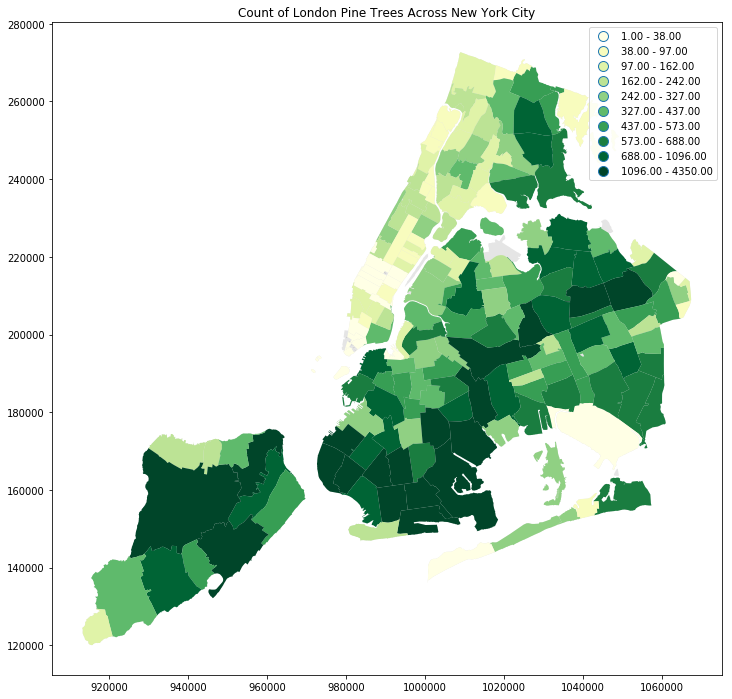

In [98]:
#plot shapefile as basemap 
#overlap with counts of pine tree in each zipcode
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
zipsNYC.plot(ax=ax, color='black', alpha=0.1)
dfmap.plot(ax=ax, column='spc_common',cmap='YlGn',scheme='quantiles',k=10,legend=True);
plt.title('Count of London Pine Trees Across New York City', size=12)

In [99]:
#merge both based on zipcode
dfmapas = pd.merge(zipsNYC, dfjoin, left_on='ZIPCODE', right_on='postcode')
dfmapas

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,postcode,pine_count,discharges_count,discharge_rate
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,452,153.0,27.5
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,413,852.0,43.7
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,1067,1567.0,59.5
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,442,548.0,30.7
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,1016,272.0,11.7
5,11226,0,Brooklyn,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994821.4729396403 177865.7178093046,...",11226,327,1112.0,35.9
6,11219,0,Brooklyn,92561.0,4.200274e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((987286.3515269756 173946.4621963799,...",11219,890,195.0,6.9
7,11210,0,Brooklyn,67067.0,4.788702e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995796.0097044706 171110.0666224658,...",11210,688,417.0,21.1
8,11230,0,Brooklyn,80857.0,4.992670e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((994099.2959063053 171240.7064530551,...",11230,1166,293.0,11.7
9,11204,0,Brooklyn,77354.0,4.355518e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((989500.1699339747 170730.1687602103,...",11204,1365,177.0,7.2


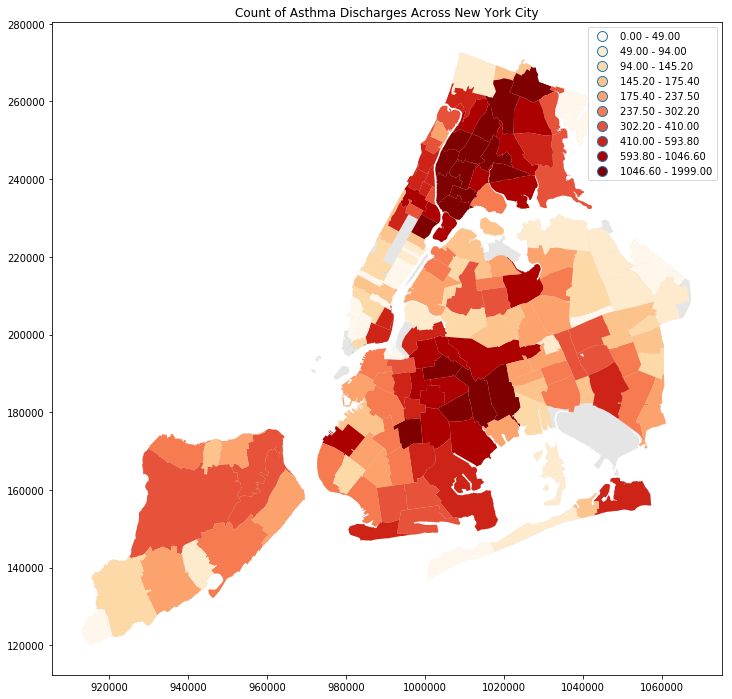

In [100]:
#plot shapefile as basemap 
#overlap with counts of pine tree in each zipcode
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
zipsNYC.plot(ax=ax, color='black', alpha=0.1)
dfmapas.plot(ax=ax, column='discharges_count',cmap='OrRd',scheme='quantiles',k=10,legend=True);
plt.title('Count of Asthma Discharges Across New York City', size=12)